In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

In [ ]:
! pip install mediapipe

  Using cached mediapipe-0.8.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.7 MB)


In [ ]:
import mediapipe as mp

In [ ]:
tf.__version__

'2.8.0'

## Dataset 

In [ ]:
# initialize mediapipe 
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

bg_image = cv2.imread("blank.jpg")

In [ ]:
def remove_background(img):
  
    frame = cv2.flip(img, 1)
   
    height , width, channel = frame.shape

    RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # get the result 
    results = selfie_segmentation.process(RGB)

    # extract segmented mask
    mask = results.segmentation_mask

    # it returns true or false where the condition applies in the mask
    condition = np.stack(
      (results.segmentation_mask,) * 3, axis=-1) > 0.6
    
    bg_image = cv2.imread("blank.jpg")
    # resize the background image to the same size of the original frame
    bg_image = cv2.resize(bg_image, (width, height))

    # combine frame and background image using the condition
    output_image = np.where(condition, frame, bg_image)

    return output_image
    

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/content/drive/MyDrive/Dataset/image9'
img_array = []

sketch_path = '/content/drive/MyDrive/Dataset/result9'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)

    #image=remove_background(image)

    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    

    

100%|██████████| 3100/3100 [00:15<00:00, 198.30it/s]


In [ ]:
print("Total number of sketch images:",len(sketch_array))
print("Total number of images:",len(img_array))

Total number of sketch images: 3100
Total number of images: 3100


In [ ]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
    plt.show()

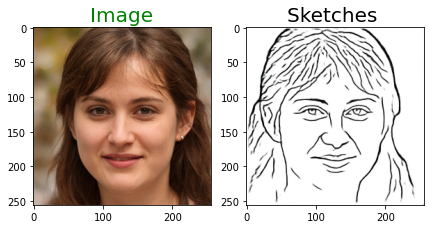

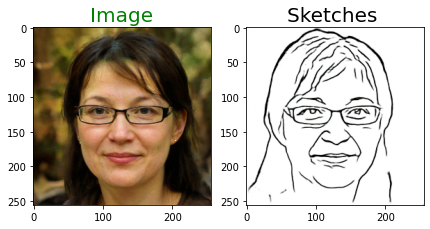

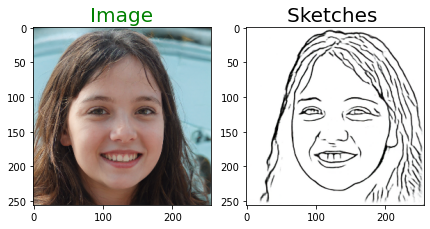

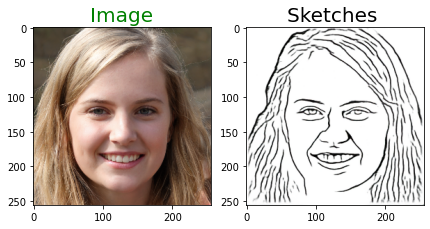

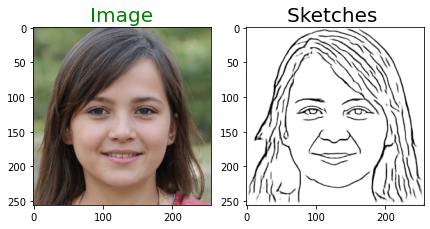

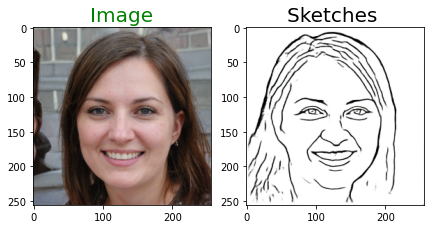

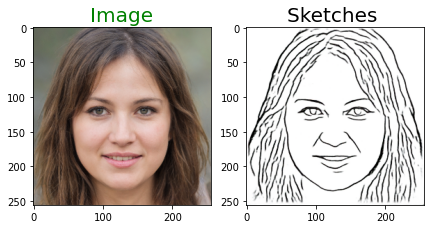

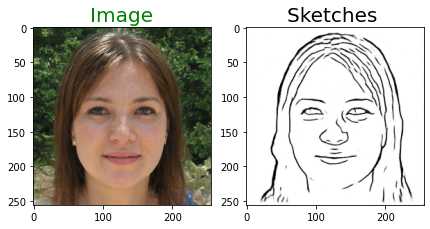

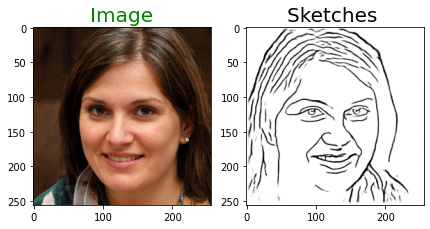

In [ ]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [ ]:
dist=2800
train_sketch_image = sketch_array[:dist]
train_image = img_array[:dist]
test_sketch_image = sketch_array[dist:dist+100]
test_image = img_array[dist:dist+100]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)


Train color image shape: (2800, 256, 256, 3)
Test color image shape (100, 256, 256, 3)


In [ ]:
import gc
del img_array
del sketch_array
gc.collect()

37845

In [ ]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.ReLU())
    return downsample

In [ ]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.ReLU()) 
    return upsample

In [ ]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)

        
    
    


In [ ]:
# to get summary of model
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 127, 127, 16)      768       
                                                                 
 sequential_1 (Sequential)   (None, 62, 62, 32)        8320      
                                                                 
 sequential_2 (Sequential)   (None, 30, 30, 64)        32768     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       131584    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         525312    
                                                                 
 sequential_5 (Sequential)   (None, 2, 2, 512)         209920

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_sketch_image, train_image, epochs = 200, verbose = 1)

Epoch 1/200
88/88 [==============================] - 24s 130ms/step - loss: 0.1812 - acc: 0.7409
Epoch 2/200
88/88 [==============================] - 10s 118ms/step - loss: 0.1319 - acc: 0.8785
Epoch 3/200
88/88 [==============================] - 10s 119ms/step - loss: 0.1180 - acc: 0.8814
Epoch 4/200
88/88 [==============================] - 10s 119ms/step - loss: 0.1066 - acc: 0.8784
Epoch 5/200
88/88 [==============================] - 11s 120ms/step - loss: 0.0993 - acc: 0.8745
Epoch 6/200
88/88 [==============================] - 11s 121ms/step - loss: 0.0929 - acc: 0.8743
Epoch 7/200
88/88 [==============================] - 11s 121ms/step - loss: 0.0884 - acc: 0.8766
Epoch 8/200
88/88 [==============================] - 11s 122ms/step - loss: 0.0862 - acc: 0.8774
Epoch 9/200
88/88 [==============================] - 11s 122ms/step - loss: 0.0851 - acc: 0.8791
Epoch 10/200
88/88 [==============================] - 11s 123ms/step - loss: 0.0810 - acc: 0.8785
Epoch 11/200
88/88 [=========

In [ ]:
model.save("/content/drive/MyDrive/model clg /model_9.h5")

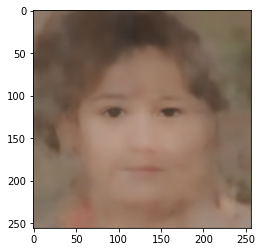

In [ ]:
sketch_path="/content/art.jpg"
SIZE=256
image=cv2.imread(sketch_path)
# as opencv load image in bgr format converting it to rgb

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# resizing images 
image = cv2.resize(image, (SIZE, SIZE))

# normalizing image 
image = image.astype('float32') / 255.0

predicted =np.clip(model.predict(image.reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)

plt.imshow(predicted)

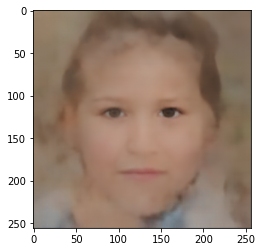

In [ ]:
sketch_path="/content/download.jpg"
SIZE=256
image=cv2.imread(sketch_path)
# as opencv load image in bgr format converting it to rgb
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# resizing images 
image = cv2.resize(image, (SIZE, SIZE))

# normalizing image 
image = image.astype('float32') / 255.0

predicted =np.clip(model.predict(image.reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)

plt.imshow(predicted)

In [ ]:
model.save("model_on_image_maskwala.h5")

In [ ]:
s=list("asefassadsda")
j=list("aeiou")
for i in range(len(s)-2):
  if s[i] in j and s[i+1] in j:
    print(s.index(s[i]))
    break
else:
  print(-1)


-1


# Testing all models performance